In [25]:
from math import ceil
import numpy as np
demand = [
        ceil(abs(np.random.normal(17, 7, 1)[0])),
        ceil(abs(np.random.normal(14, 6, 1)[0])),
        ceil(abs(np.random.normal(13, 4, 1)[0])),
        ceil(abs(np.random.normal(16, 6, 1)[0]))
        ]
np.random.seed(1321)
demand


[15, 13, 6, 20]

Total cost for episode 1: 3058.8269115398407
Replenished by trucks for episode 1: [10.  5. 20. 20.]
Total cost for episode 2: 748.0747495512956
Replenished by trucks for episode 2: [30. 15. 10.  0.]
Total cost for episode 3: 3558.8269115398407
Replenished by trucks for episode 3: [ 5. 10. 15. 25.]
Total cost for episode 4: 3058.8269115398407
Replenished by trucks for episode 4: [15.  5. 10. 20.]
Total cost for episode 5: 748.2712971677428
Replenished by trucks for episode 5: [20. 10. 10.  0.]
Total cost for episode 6: 845.2921307118152
Replenished by trucks for episode 6: [ 5. 10. 15.  0.]
Total cost for episode 7: 4558.826911539841
Replenished by trucks for episode 7: [20.  5. 20. 35.]
Total cost for episode 8: 748.2712971677428
Replenished by trucks for episode 8: [25. 20. 35.  0.]
Total cost for episode 9: 3558.8269115398407
Replenished by trucks for episode 9: [20. 10. 20. 25.]
Total cost for episode 10: 2058.8269115398407
Replenished by trucks for episode 10: [25. 30. 15. 10.]


<module 'matplotlib.pyplot' from 'c:\\Anacondainstalledhere\\envs\\Ai\\Lib\\site-packages\\matplotlib\\pyplot.py'>

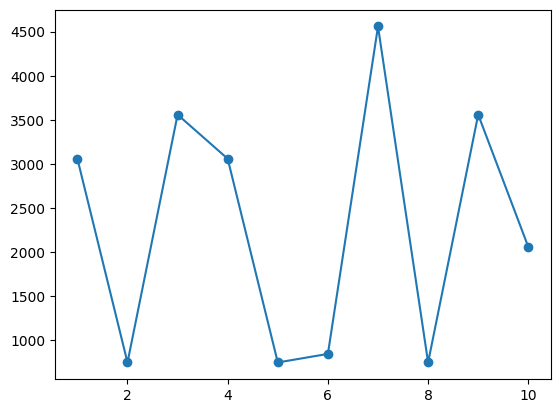

In [6]:
import numpy as np
from math import ceil
from scipy.stats import norm
import geopy.distance

class sSpolicy:
    def __init__(self, nStores=4, num_trucks=4):
        self.data = dict()
        self.nStores = nStores
        self.num_trucks = num_trucks
        
        # Latitude coordinates; First element is depot
        self.lat = np.array([52.4572735973313,
                             52.533031250357,
                             52.5326620602486,
                             52.4965099365104,
                             52.4921203344399
                             ])
        
        # Longitude coordinates, first element is depot
        self.lon = np.array([13.3878670887734,
                             13.387585268824,
                             13.398873880729,
                             13.4224855541126,
                             13.4226572154896,
                             ])
        
        self.data['distance_matrix'] = np.zeros(shape=[self.nStores + 1, self.nStores + 1])
        
        # Variable transport cost per unit distance
        self.transportCost = 5
        
        # Fixed transport cost per used route
        self.fixedTransportCost = 100
        
        # The distance matrix is in the end the cost matrix. We take the distance
        # between coordinates and multiply it with the variable transportCost
        for i in range(0, self.nStores + 1):
            for j in range(0, self.nStores + 1):
                coords_1 = (self.lat[i], self.lon[i])
                coords_2 = (self.lat[j], self.lon[j])
                self.data['distance_matrix'][i][j] = geopy.distance.geodesic(coords_1, coords_2).km * self.transportCost
                                           
        # The vehicle capacity and the number of vehicles.
        self.data['vehicle_capacity'] = 50
        self.data['num_vehicles'] = self.num_trucks

        # Information of the stores (holding cost, lost-sales cost, capacity)
        self.c_holding = 100 
        self.c_lost = 100
        self.capacity = 1000
        
        self.orderUpTo = 100

    def demand(self):
        demand = [
            ceil(abs(np.random.normal(17, 7, 1)[0])),
            ceil(abs(np.random.normal(14, 6, 1)[0])),
            ceil(abs(np.random.normal(13, 4, 1)[0])),
            ceil(abs(np.random.normal(16, 6, 1)[0]))
        ]
        return demand
    
    def base_stock_level(self):
        c_holding = 100 
        c_lost = 100
    
        critical_ratio = c_lost / (c_lost + c_holding)
        k = norm.ppf(critical_ratio)
    
        # Call demand function to get demand for each store
        demand_values = self.demand()
    
        # Calculate base stock level for each store
        std_deviation = np.std(demand_values)
        base_stock_level = [demand_values[i] + k * std_deviation for i in range(4)]
    
        return base_stock_level
    
    def define_actions(self):
        actions = list(range(0, int(self.orderUpTo) + 1, 5))
        return actions

    def reset(self):
        self.inventories = self.base_stock_level()
        return self.inventories

    def step(self):
        # Call the action definition
        actions = self.define_actions()
        
        # Initialize costs and other variables
        inventory = np.zeros(self.nStores)
        replenishment = np.zeros(self.nStores)
        
        # Get current inventories
        current_inventories = self.reset()
        
        # Calculate demand
        current_demand = self.demand()
        
        # Calculate replenishment needed for each store
        for i in range(self.nStores):
            inventory[i] = current_inventories[i] - current_demand[i]
            if inventory[i] < self.base_stock_level()[i]:
                replenishment_needed = self.base_stock_level()[i] - inventory[i]
                replenishment[i] = min([a for a in actions if a >= replenishment_needed], default=0)
            else:
                replenishment[i] = 0

        trucks_load = np.zeros(self.num_trucks)
        replenished_by_trucks = np.zeros(self.num_trucks)
        routes = [[] for _ in range(self.num_trucks)]
        lost_sales = 0
        total_distance = 0
        
        truck_index = 0
        
        for j in range(len(replenishment)):
            if replenishment[j] != 0:
                total_distance += self.data['distance_matrix'][0][j + 1]  # Add distance from depot to store
                if replenishment[j] <= self.data['vehicle_capacity']:
                    replenished_by_trucks[truck_index] = replenishment[j]
                    routes[truck_index].append(j)
                    truck_index += 1
                else:
                    while replenishment[j] > 0 and truck_index < self.num_trucks:
                        if replenishment[j] > self.data['vehicle_capacity']:
                            replenished_by_trucks[truck_index] = self.data['vehicle_capacity']
                            replenishment[j] -= self.data['vehicle_capacity']
                            routes[truck_index].append(j)
                            truck_index += 1
                        else:
                            replenished_by_trucks[truck_index] = replenishment[j]
                            routes[truck_index].append(j)
                            replenishment[j] = 0
                
                if truck_index >= self.num_trucks:
                    lost_sales += replenishment[j]
                    replenishment[j] = 0
            
        # Calculate the total cost
        variable_transport_cost = total_distance * self.transportCost
        fixed_transport_cost = (self.num_trucks - np.count_nonzero(replenished_by_trucks == 0)) * self.fixedTransportCost
        lost_sales_cost = lost_sales * self.c_lost
        total_cost = variable_transport_cost + fixed_transport_cost + lost_sales_cost
        
        return inventory, replenishment, trucks_load, replenished_by_trucks, routes, lost_sales, total_distance, total_cost

# Run the algorithm for 10 episodes
num_episodes = 10
total_costs = []
all_replenished_by_trucks = []

for episode in range(num_episodes):
    # Set a different random seed for each episode
    np.random.seed(1331 + episode)
    
    # Initialize an instance of sSpolicy class for each episode
    ssp = sSpolicy(4)
    
    # Run the step method to get the total cost and replenished_by_trucks
    _, _, _, replenished_by_trucks, _, _, _, total_cost = ssp.step()
    
    # Append the total cost and replenished_by_trucks to the lists
    total_costs.append(total_cost)
    all_replenished_by_trucks.append(replenished_by_trucks)

# Print total costs for all episodes and the corresponding replenished_by_trucks
for i, (cost, replenished) in enumerate(zip(total_costs, all_replenished_by_trucks)):
    print(f"Total cost for episode {i+1}: {cost}")
    print(f"Replenished by trucks for episode {i+1}: {replenished}")
# Plot total costs for all episodes
plt.plot(range(1, num_episodes + 1), total_costs, marker='o')
plt

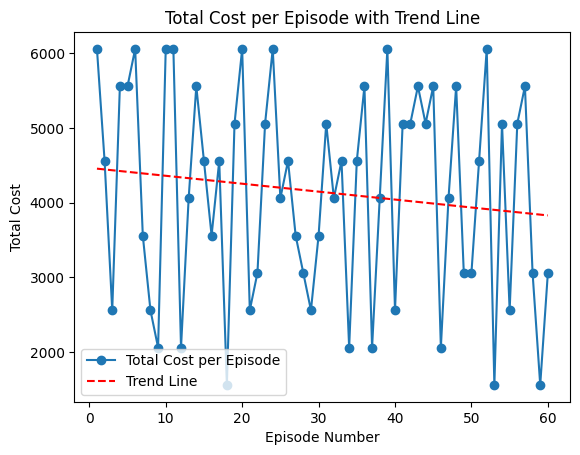

Replenished by trucks for episode 1: [50. 40. 50. 50.]
Replenished by trucks for episode 2: [35. 50. 50. 50.]
Replenished by trucks for episode 3: [50. 15. 50. 50.]
Replenished by trucks for episode 4: [50. 25. 50. 45.]
Replenished by trucks for episode 5: [50. 50. 20. 50.]
Replenished by trucks for episode 6: [40. 50. 50. 50.]
Replenished by trucks for episode 7: [50. 50. 50. 50.]
Replenished by trucks for episode 8: [40. 50. 35. 50.]
Replenished by trucks for episode 9: [50. 15. 50. 50.]
Replenished by trucks for episode 10: [50. 20. 50. 50.]
Replenished by trucks for episode 11: [50. 50. 50. 50.]
Replenished by trucks for episode 12: [40. 20. 20. 10.]
Replenished by trucks for episode 13: [50. 50. 25. 30.]
Replenished by trucks for episode 14: [15. 50. 40. 45.]
Replenished by trucks for episode 15: [50. 50. 50. 35.]
Replenished by trucks for episode 16: [45. 50. 50. 25.]
Replenished by trucks for episode 17: [50. 50. 40. 35.]
Replenished by trucks for episode 18: [25. 50. 50. 50.]
R

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from math import ceil
from scipy.stats import norm
import geopy.distance
import random

class sSpolicy:
    def __init__(self, nStores=4, num_trucks=4):
        self.data = dict()
        self.nStores = nStores
        self.num_trucks = num_trucks
        
        # Latitude coordinates; First element is depot
        self.lat = np.array([52.4572735973313,
                             52.533031250357,
                             52.5326620602486,
                             52.4965099365104,
                             52.4921203344399
                             ])
        
        # Longitude coordinates, first element is depot
        self.lon = np.array([13.3878670887734,
                             13.387585268824,
                             13.398873880729,
                             13.4224855541126,
                             13.4226572154896,
                             ])
        
        self.data['distance_matrix'] = np.zeros(shape=[self.nStores + 1, self.nStores + 1])
        
        # Variable transport cost per unit distance
        self.transportCost = 5
        
        # Fixed transport cost per used route
        self.fixedTransportCost = 100
        
        # The distance matrix is in the end the cost matrix. We take the distance
        # between coordinates and multiply it with the variable transportCost
        for i in range(0, self.nStores + 1):
            for j in range(0, self.nStores + 1):
                coords_1 = (self.lat[i], self.lon[i])
                coords_2 = (self.lat[j], self.lon[j])
                self.data['distance_matrix'][i][j] = geopy.distance.geodesic(coords_1, coords_2).km * self.transportCost
                                           
        # The vehicle capacity and the number of vehicles.
        self.data['vehicle_capacity'] = 50
        self.data['num_vehicles'] = self.num_trucks

        # Information of the stores (holding cost, lost-sales cost, capacity)
        self.c_holding = 100 
        self.c_lost = 100
        self.capacity = 1000
        
        self.orderUpTo = 100

    def demand(self):
        demand = [
            ceil(abs(np.random.normal(17, 7, 1)[0])),
            ceil(abs(np.random.normal(14, 6, 1)[0])),
            ceil(abs(np.random.normal(13, 4, 1)[0])),
            ceil(abs(np.random.normal(16, 6, 1)[0]))
        ]
        return demand
    
    def base_stock_level(self):
        c_holding = 100 
        c_lost = 100
    
        critical_ratio = c_lost / (c_lost + c_holding)
        k = norm.ppf(critical_ratio)
    
        # Call demand function to get demand for each store
        demand_values = self.demand()
    
        # Calculate base stock level for each store
        std_deviation = np.std(demand_values)
        base_stock_level = [ceil(demand_values[i] + k * std_deviation) for i in range(self.nStores)]
    
        return base_stock_level
    
    def define_actions(self):
        actions = list(range(0, int(self.orderUpTo) + 1, 5))
        return actions

    def reset(self):
        self.inventories = self.base_stock_level()
        return self.inventories

    def step(self, action):
        # Initialize costs and other variables
        inventory = np.zeros(self.nStores)
        replenishment = action
        
        # Get current inventories
        current_inventories = self.reset()
        
        # Calculate demand
        current_demand = self.demand()
        
        # Calculate replenishment needed for each store
        for i in range(self.nStores):
            inventory[i] = current_inventories[i] - current_demand[i]

        trucks_load = np.zeros(self.num_trucks)
        replenished_by_trucks = np.zeros(self.num_trucks)
        routes = [[] for _ in range(self.num_trucks)]
        lost_sales = 0
        total_distance = 0
        
        truck_index = 0
        
        for j in range(len(replenishment)):
            if replenishment[j] != 0:
                total_distance += self.data['distance_matrix'][0][j + 1]  # Add distance from depot to store
                if replenishment[j] <= self.data['vehicle_capacity']:
                    replenished_by_trucks[truck_index] = replenishment[j]
                    routes[truck_index].append(j)
                    truck_index += 1
                else:
                    while replenishment[j] > 0 and truck_index < self.num_trucks:
                        if replenishment[j] > self.data['vehicle_capacity']:
                            replenished_by_trucks[truck_index] = self.data['vehicle_capacity']
                            replenishment[j] -= self.data['vehicle_capacity']
                            routes[truck_index].append(j)
                            truck_index += 1
                        else:
                            replenished_by_trucks[truck_index] = replenishment[j]
                            routes[truck_index].append(j)
                            replenishment[j] = 0
                
                if truck_index >= self.num_trucks:
                    lost_sales += replenishment[j]
                    replenishment[j] = 0
            
        # Calculate the total cost
        variable_transport_cost = total_distance * self.transportCost
        fixed_transport_cost = (self.num_trucks - np.count_nonzero(replenished_by_trucks == 0)) * self.fixedTransportCost
        lost_sales_cost = lost_sales * self.c_lost
        total_cost = variable_transport_cost + fixed_transport_cost + lost_sales_cost
        
        return inventory, replenishment, trucks_load, replenished_by_trucks, routes, lost_sales, total_distance, total_cost

# Initialize Q-table
Q_table = {}

# Parameters for Q-learning
discount_value = 0.6
num_episodes = 60
total_costs = []
all_replenished_by_trucks = []

# Epsilon decay parameters
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.99

for episode in range(num_episodes):
    # Set a different random seed for each episode
    np.random.seed(1331 + episode)
    
    # Initialize an instance of sSpolicy class for each episode
    ssp = sSpolicy(4)
    
    # Get the replenishment needed for the current state
    replenishment_needed = ssp.base_stock_level()
    
    # Define actions
    actions = ssp.define_actions()
    
    if episode < 20:
        # For the first 20 episodes, choose actions randomly
        action = [random.choice([a for a in actions if a >= need]) for need in replenishment_needed]
        
        # Calculate cost as replenishment * 10
        costs = [a * 10 for a in action]
        
        # Update Q-table
        Q_table[(tuple(replenishment_needed), tuple(action))] = sum(costs)
    else:
        # For the next 40 episodes, use epsilon-greedy strategy
        if np.random.rand() < epsilon:
            # Choose a random action
            action = [random.choice([a for a in actions if a >= need]) for need in replenishment_needed]
        else:
            # Choose the best action from Q-table
            state_action_pairs = [(k, v) for k, v in Q_table.items() if k[0] == tuple(replenishment_needed)]
            if state_action_pairs:
                action = min(state_action_pairs, key=lambda x: x[1])[0][1]
            else:
                action = [random.choice([a for a in actions if a >= need]) for need in replenishment_needed]
        
        # Calculate cost as replenishment * 10
        costs = [a * 10 for a in action]
        
        # Update Q-table using Bellman equation
        state_action = (tuple(replenishment_needed), tuple(action))
        if state_action in Q_table:
            old_cost = Q_table[state_action]
            new_cost = sum(costs) + discount_value * old_cost
            Q_table[state_action] = new_cost
        else:
            Q_table[state_action] = sum(costs)
    
    # Run the step method to get the total cost and replenished_by_trucks
    _, _, _, replenished_by_trucks, _, _, _, total_cost = ssp.step(action)
    
    # Append the total cost and replenished_by_trucks to the lists
    total_costs.append(total_cost)
    all_replenished_by_trucks.append(replenished_by_trucks)
    
    # Decay epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

# Plot total costs for all episodes
plt.plot(range(1, num_episodes + 1), total_costs, marker='o', label='Total Cost per Episode')

# Calculate the trend line
slope, intercept, r_value, p_value, std_err = linregress(range(1, num_episodes + 1), total_costs)
trend_line = [slope * x + intercept for x in range(1, num_episodes + 1)]

# Plot the trend line
plt.plot(range(1, num_episodes + 1), trend_line, color='red', linestyle='--', label='Trend Line')
plt.xlabel('Episode Number')
plt.ylabel('Total Cost')
plt.title('Total Cost per Episode with Trend Line')
plt.legend()
plt.show()

# Print replenished_by_trucks for each episode
for i, trucks in enumerate(all_replenished_by_trucks):
    print(f"Replenished by trucks for episode {i + 1}: {trucks}")


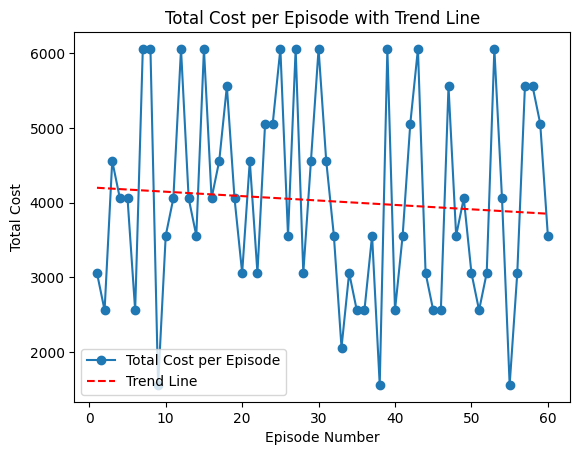

Replenished by trucks for episode 1: [50. 50. 50. 20.]
Replenished by trucks for episode 2: [50. 50. 40. 50.]
Replenished by trucks for episode 3: [35. 40. 30. 50.]
Replenished by trucks for episode 4: [50. 50. 50. 30.]
Replenished by trucks for episode 5: [30. 50. 15. 50.]
Replenished by trucks for episode 6: [45. 50. 45. 50.]
Replenished by trucks for episode 7: [45. 50. 50. 50.]
Replenished by trucks for episode 8: [25. 50. 50. 50.]
Replenished by trucks for episode 9: [50. 50. 50. 50.]
Replenished by trucks for episode 10: [50. 50. 45. 25.]
Replenished by trucks for episode 11: [50. 25. 50. 50.]
Replenished by trucks for episode 12: [45. 50. 50. 50.]
Replenished by trucks for episode 13: [50. 35. 50. 30.]
Replenished by trucks for episode 14: [50. 45. 40. 50.]
Replenished by trucks for episode 15: [45. 50. 50. 50.]
Replenished by trucks for episode 16: [25. 50. 50. 50.]
Replenished by trucks for episode 17: [50. 50. 50. 50.]
Replenished by trucks for episode 18: [50. 50. 25. 45.]
R

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from math import ceil
from scipy.stats import norm
import geopy.distance
import random

class sSpolicy:
    def __init__(self, nStores=4, num_trucks=4):
        self.data = dict()
        self.nStores = nStores
        self.num_trucks = num_trucks
        
        # Latitude coordinates; First element is depot
        self.lat = np.array([52.4572735973313,
                             52.533031250357,
                             52.5326620602486,
                             52.4965099365104,
                             52.4921203344399
                             ])
        
        # Longitude coordinates, first element is depot
        self.lon = np.array([13.3878670887734,
                             13.387585268824,
                             13.398873880729,
                             13.4224855541126,
                             13.4226572154896,
                             ])
        
        self.data['distance_matrix'] = np.zeros(shape=[self.nStores + 1, self.nStores + 1])
        
        # Variable transport cost per unit distance
        self.transportCost = 5
        
        # Fixed transport cost per used route
        self.fixedTransportCost = 100
        
        # The distance matrix is in the end the cost matrix. We take the distance
        # between coordinates and multiply it with the variable transportCost
        for i in range(0, self.nStores + 1):
            for j in range(0, self.nStores + 1):
                coords_1 = (self.lat[i], self.lon[i])
                coords_2 = (self.lat[j], self.lon[j])
                self.data['distance_matrix'][i][j] = geopy.distance.geodesic(coords_1, coords_2).km * self.transportCost
                                           
        # The vehicle capacity and the number of vehicles.
        self.data['vehicle_capacity'] = 50
        self.data['num_vehicles'] = self.num_trucks

        # Information of the stores (holding cost, lost-sales cost, capacity)
        self.c_holding = 100 
        self.c_lost = 100
        self.capacity = 1000
        
        self.orderUpTo = 100

    def demand(self):
        demand = [
            ceil(abs(np.random.normal(17, 7, 1)[0])),
            ceil(abs(np.random.normal(14, 6, 1)[0])),
            ceil(abs(np.random.normal(13, 4, 1)[0])),
            ceil(abs(np.random.normal(16, 6, 1)[0]))
        ]
        return demand
    
    def base_stock_level(self):
        c_holding = 100 
        c_lost = 100
    
        critical_ratio = c_lost / (c_lost + c_holding)
        k = norm.ppf(critical_ratio)
    
        # Call demand function to get demand for each store
        demand_values = self.demand()
    
        # Calculate base stock level for each store
        std_deviation = np.std(demand_values)
        base_stock_level = [ceil(demand_values[i] + k * std_deviation) for i in range(self.nStores)]
    
        return base_stock_level
    
    def define_actions(self):
        actions = list(range(0, int(self.orderUpTo) + 1, 5))
        return actions

    def reset(self):
        self.inventories = self.base_stock_level()
        return self.inventories

    def step(self, action):
        # Initialize costs and other variables
        inventory = np.zeros(self.nStores)
        replenishment = action
        
        # Get current inventories
        current_inventories = self.reset()
        
        # Calculate demand
        current_demand = self.demand()
        
        # Calculate replenishment needed for each store
        for i in range(self.nStores):
            inventory[i] = current_inventories[i] - current_demand[i]

        trucks_load = np.zeros(self.num_trucks)
        replenished_by_trucks = np.zeros(self.num_trucks)
        routes = [[] for _ in range(self.num_trucks)]
        lost_sales = 0
        total_distance = 0
        
        truck_index = 0
        
        for j in range(len(replenishment)):
            if replenishment[j] != 0:
                total_distance += self.data['distance_matrix'][0][j + 1]  # Add distance from depot to store
                if replenishment[j] <= self.data['vehicle_capacity']:
                    replenished_by_trucks[truck_index] = replenishment[j]
                    routes[truck_index].append(j)
                    truck_index += 1
                else:
                    while replenishment[j] > 0 and truck_index < self.num_trucks:
                        if replenishment[j] > self.data['vehicle_capacity']:
                            replenished_by_trucks[truck_index] = self.data['vehicle_capacity']
                            replenishment[j] -= self.data['vehicle_capacity']
                            routes[truck_index].append(j)
                            truck_index += 1
                        else:
                            replenished_by_trucks[truck_index] = replenishment[j]
                            routes[truck_index].append(j)
                            replenishment[j] = 0
                
                if truck_index >= self.num_trucks:
                    lost_sales += replenishment[j]
                    replenishment[j] = 0
            
        # Calculate the total cost
        variable_transport_cost = total_distance * self.transportCost
        fixed_transport_cost = (self.num_trucks - np.count_nonzero(replenished_by_trucks == 0)) * self.fixedTransportCost
        lost_sales_cost = lost_sales * self.c_lost
        total_cost = variable_transport_cost + fixed_transport_cost + lost_sales_cost
        
        return inventory, replenishment, trucks_load, replenished_by_trucks, routes, lost_sales, total_distance, total_cost

# Initialize Q-table
Q_table = {}

# Parameters for Q-learning
discount_value = 0.6
num_episodes = 60
total_costs = []
all_replenished_by_trucks = []

# Epsilon decay parameters
epsilon = 0.2
epsilon_min = 0.05
epsilon_decay = 0.95

for episode in range(num_episodes):
    # Set a different random seed for each episode
    np.random.seed(1331 + episode)
    
    # Initialize an instance of sSpolicy class for each episode
    ssp = sSpolicy(4)
    
    # Get the replenishment needed for the current state
    replenishment_needed = ssp.base_stock_level()
    
    # Define actions
    actions = ssp.define_actions()
    
    if episode < 20:
        # For the first 20 episodes, choose actions randomly
        action = [random.choice([a for a in actions if a >= need]) for need in replenishment_needed]
        
        # Calculate cost as replenishment * 10
        costs = [a * 10 for a in action]
        
        # Update Q-table
        Q_table[(tuple(replenishment_needed), tuple(action))] = sum(costs)
    else:
        # For the next 40 episodes, use epsilon-greedy strategy
        if np.random.rand() < epsilon:
            # Choose a random action
            action = [random.choice([a for a in actions if a >= need]) for need in replenishment_needed]
        else:
            # Choose the best action from Q-table
            state_action_pairs = [(k, v) for k, v in Q_table.items() if k[0] == tuple(replenishment_needed)]
            if state_action_pairs:
                action = min(state_action_pairs, key=lambda x: x[1])[0][1]
            else:
                action = [random.choice([a for a in actions if a >= need]) for need in replenishment_needed]
        
        # Calculate cost as replenishment * 10
        costs = [a * 10 for a in action]
        
        # Update Q-table using Bellman equation
        state_action = (tuple(replenishment_needed), tuple(action))
        if state_action in Q_table:
            old_cost = Q_table[state_action]
            new_cost = sum(costs) + discount_value * old_cost
            Q_table[state_action] = new_cost
        else:
            Q_table[state_action] = sum(costs)
    
    # Run the step method to get the total cost and replenished_by_trucks
    _, _, _, replenished_by_trucks, _, _, _, total_cost = ssp.step(action)
    
    # Append the total cost and replenished_by_trucks to the lists
    total_costs.append(total_cost)
    all_replenished_by_trucks.append(replenished_by_trucks)
    
    # Decay epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

# Plot total costs for all episodes
plt.plot(range(1, num_episodes + 1), total_costs, marker='o', label='Total Cost per Episode')

# Calculate the trend line
slope, intercept, r_value, p_value, std_err = linregress(range(1, num_episodes + 1), total_costs)
trend_line = [slope * x + intercept for x in range(1, num_episodes + 1)]

# Plot the trend line
plt.plot(range(1, num_episodes + 1), trend_line, color='red', linestyle='--', label='Trend Line')
plt.xlabel('Episode Number')
plt.ylabel('Total Cost')
plt.title('Total Cost per Episode with Trend Line')
plt.legend()
plt.show()

# Print replenished_by_trucks for each episode
for i, trucks in enumerate(all_replenished_by_trucks):
    print(f"Replenished by trucks for episode {i + 1}: {trucks}")


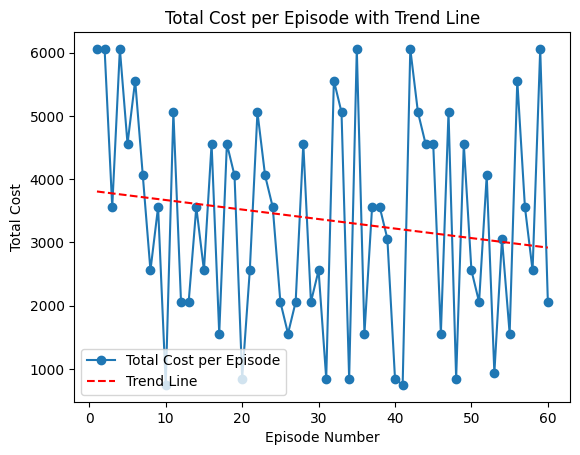

Replenished by trucks for episode 1: [20. 30. 30. 50.]
Replenished by trucks for episode 2: [50. 50. 30. 50.]
Replenished by trucks for episode 3: [50. 50. 50. 25.]
Replenished by trucks for episode 4: [50. 20. 50. 50.]
Replenished by trucks for episode 5: [25. 50. 30. 35.]
Replenished by trucks for episode 6: [50. 50. 50. 45.]
Replenished by trucks for episode 7: [50. 50. 20. 50.]
Replenished by trucks for episode 8: [40. 50. 35. 50.]
Replenished by trucks for episode 9: [ 5. 35. 35. 50.]
Replenished by trucks for episode 10: [50. 50. 20.  0.]
Replenished by trucks for episode 11: [50. 50. 20. 50.]
Replenished by trucks for episode 12: [50. 50. 50. 50.]
Replenished by trucks for episode 13: [50. 50. 50. 50.]
Replenished by trucks for episode 14: [50. 50. 40. 25.]
Replenished by trucks for episode 15: [50. 50. 30. 15.]
Replenished by trucks for episode 16: [50. 50. 50. 50.]
Replenished by trucks for episode 17: [50. 50. 25.  5.]
Replenished by trucks for episode 18: [50. 50. 50. 50.]
R

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from math import ceil
from scipy.stats import norm
import geopy.distance
import random

class sSpolicy:
    def __init__(self, nStores=4, num_trucks=4):
        self.data = dict()
        self.nStores = nStores
        self.num_trucks = num_trucks
        
        # Latitude coordinates; First element is depot
        self.lat = np.array([52.4572735973313,
                             52.533031250357,
                             52.5326620602486,
                             52.4965099365104,
                             52.4921203344399
                             ])
        
        # Longitude coordinates, first element is depot
        self.lon = np.array([13.3878670887734,
                             13.387585268824,
                             13.398873880729,
                             13.4224855541126,
                             13.4226572154896,
                             ])
        
        self.data['distance_matrix'] = np.zeros(shape=[self.nStores + 1, self.nStores + 1])
        
        # Variable transport cost per unit distance
        self.transportCost = 5
        
        # Fixed transport cost per used route
        self.fixedTransportCost = 100
        
        # The distance matrix is in the end the cost matrix. We take the distance
        # between coordinates and multiply it with the variable transportCost
        for i in range(0, self.nStores + 1):
            for j in range(0, self.nStores + 1):
                coords_1 = (self.lat[i], self.lon[i])
                coords_2 = (self.lat[j], self.lon[j])
                self.data['distance_matrix'][i][j] = geopy.distance.geodesic(coords_1, coords_2).km * self.transportCost
                                           
        # The vehicle capacity and the number of vehicles.
        self.data['vehicle_capacity'] = 50
        self.data['num_vehicles'] = self.num_trucks

        # Information of the stores (holding cost, lost-sales cost, capacity)
        self.c_holding = 100 
        self.c_lost = 100
        self.capacity = 1000
        #here s,S policy is formualated as s < S and can hold any value. So when a inventory is less than 'S'at s, demand is formulated
        self.orderUpTo = 100

    def demand(self):
        demand = [
            ceil(abs(np.random.normal(17, 7, 1)[0])),
            ceil(abs(np.random.normal(14, 6, 1)[0])),
            ceil(abs(np.random.normal(13, 4, 1)[0])),
            ceil(abs(np.random.normal(16, 6, 1)[0]))
        ]
        return demand
    
    def base_stock_level(self):
        c_holding = 100 
        c_lost = 100
    
        critical_ratio = c_lost / (c_lost + c_holding)
        k = norm.ppf(critical_ratio)
    
        # Call demand function to get demand for each store
        demand_values = self.demand()
    
        # Calculate base stock level for each store
        std_deviation = np.std(demand_values)
        base_stock_level = [ceil(demand_values[i] + k * std_deviation) for i in range(self.nStores)]
    
        return base_stock_level
    
    def define_actions(self):
        actions = list(range(0, int(self.orderUpTo) + 1, 5))
        return actions

    def reset(self):
        self.inventories = self.base_stock_level()
        return self.inventories

    def step(self, action):
        # Initialize costs and other variables
        inventory = np.zeros(self.nStores)
        replenishment = action
        
        # Get current inventories
        current_inventories = self.reset()

        replenishment_needed = [0] * self.nStores
        
        # Calculate demand
        current_demand = self.demand()
        
        # Calculate replenishment needed for each store
        for i in range(self.nStores):
            replenishment_needed[i] = current_inventories[i] - current_demand[i]

        trucks_load = np.zeros(self.num_trucks)
        replenished_by_trucks = np.zeros(self.num_trucks)
        routes = [[] for _ in range(self.num_trucks)]
        lost_sales = 0
        total_distance = 0
        
        truck_index = 0
        
        for j in range(len(replenishment)):
            if replenishment[j] != 0:
                total_distance += self.data['distance_matrix'][0][j + 1]  # Add distance from depot to store
                if replenishment[j] <= self.data['vehicle_capacity']:
                    replenished_by_trucks[truck_index] = replenishment[j]
                    routes[truck_index].append(j)
                    truck_index += 1
                else:
                    while replenishment[j] > 0 and truck_index < self.num_trucks:
                        if replenishment[j] > self.data['vehicle_capacity']:
                            replenished_by_trucks[truck_index] = self.data['vehicle_capacity']
                            replenishment[j] -= self.data['vehicle_capacity']
                            routes[truck_index].append(j)
                            truck_index += 1
                        else:
                            replenished_by_trucks[truck_index] = replenishment[j]
                            routes[truck_index].append(j)
                            replenishment[j] = 0
                
                if truck_index >= self.num_trucks:
                    lost_sales += replenishment[j]
                    replenishment[j] = 0
            
        # Calculate the total cost
        variable_transport_cost = total_distance * self.transportCost
        fixed_transport_cost = (self.num_trucks - np.count_nonzero(replenished_by_trucks == 0)) * self.fixedTransportCost
        lost_sales_cost = lost_sales * self.c_lost
        total_cost = variable_transport_cost + fixed_transport_cost + lost_sales_cost
        
        return replenishment_needed, replenishment, trucks_load, replenished_by_trucks, routes, lost_sales, total_distance, total_cost

# Initialize Q-table
Q_table = {}

# Parameters for Q-learning
discount_value = 0.6
num_episodes = 60
total_costs = []
all_replenished_by_trucks = []

# Epsilon decay parameters
epsilon = 0.2
epsilon_min = 0.05
epsilon_decay = 0.95

for episode in range(num_episodes):
    # Set a different random seed for each episode
    np.random.seed(1331 + episode)
    
    # Initialize an instance of sSpolicy class for each episode
    ssp = sSpolicy(4)
    
    # Get the replenishment needed for the current state
    current_inventories = ssp.reset()
    replenishment_needed = [current_inventories[i] - ssp.demand()[i] for i in range(ssp.nStores)]
    
    # Define actions
    actions = ssp.define_actions()
    
    if episode < 20:
        # For the first 20 episodes, choose actions randomly
        action = [random.choice([a for a in actions if a >= need]) for need in replenishment_needed]
        
        # Calculate cost as replenishment * 10
        costs = [a * 10 for a in action]
        
        # Update Q-table
        Q_table[(tuple(replenishment_needed), tuple(action))] = sum(costs)
    else:
        # For the next 40 episodes, use epsilon-greedy strategy
        if np.random.rand() < epsilon:
            # Choose a random action
            action = [random.choice([a for a in actions if a >= need]) for need in replenishment_needed]
        else:
            # Choose the best action from Q-table
            state_action_pairs = [(k, v) for k, v in Q_table.items() if k[0] == tuple(replenishment_needed)]
            if state_action_pairs:
                action = min(state_action_pairs, key=lambda x: x[1])[0][1]
            else:
                action = [random.choice([a for a in actions if a >= need]) for need in replenishment_needed]
        
        # Calculate cost as replenishment * 10
        costs = [a * 1 for a in action]
        
        # Update Q-table using Bellman equation
        state_action = (tuple(replenishment_needed), tuple(action))
        if state_action in Q_table:
            old_cost = Q_table[state_action]
            new_cost = sum(costs) + discount_value * old_cost
            Q_table[state_action] = new_cost
        else:
            Q_table[state_action] = sum(costs)
    
    # Run the step method to get the total cost and replenished_by_trucks
    _, _, _, replenished_by_trucks, _, _, _, total_cost = ssp.step(action)
    
    # Append the total cost and replenished_by_trucks to the lists
    total_costs.append(total_cost)
    all_replenished_by_trucks.append(replenished_by_trucks)
    
    # Decay epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

# Plot total costs for all episodes
plt.plot(range(1, num_episodes + 1), total_costs, marker='o', label='Total Cost per Episode')

# Calculate the trend line
slope, intercept, r_value, p_value, std_err = linregress(range(1, num_episodes + 1), total_costs)
trend_line = [slope * x + intercept for x in range(1, num_episodes + 1)]

# Plot the trend line
plt.plot(range(1, num_episodes + 1), trend_line, color='red', linestyle='--', label='Trend Line')
plt.xlabel('Episode Number')
plt.ylabel('Total Cost')
plt.title('Total Cost per Episode with Trend Line')
plt.legend()
plt.show()

# Print replenished_by_trucks for each episode
for i, trucks in enumerate(all_replenished_by_trucks):
    print(f"Replenished by trucks for episode {i + 1}: {trucks}")

# Print the lowest total cost of all the episodes
lowest_total_cost = min(total_costs)
print(f"The lowest total cost of all the episodes is: {lowest_total_cost}")